# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [9]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.tree import DecisionTreeClassifier

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [10]:

# using the SQLite Table to read data.
con = sqlite3.connect(r'C:\Sandy\privy\AI\Data Sets\Amazon Food rev dataset\database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

#Took 3000 points from each Category i.e from Positive reviews and Negative Reviews
#Negative Data
Neg_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score < 3 LIMIT 10000""", con) 
#Positive Data
Pos_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score > 3 LIMIT 10000""", con) 

Neg_data.head()
preprocessed_data =pd.concat([Neg_data,Pos_data])
print("Total Sample Points : ",preprocessed_data.shape)
#filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con)
print("\n Sample Points : ")
preprocessed_data.head()

Total Sample Points :  (20000, 10)

 Sample Points : 


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
1,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
2,13,B0009XLVG0,A327PCT23YH90,LT,1,1,1,1339545600,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...
3,17,B001GVISJM,A3KLWF6WQ5BNYO,Erica Neathery,0,0,2,1348099200,poor taste,I love eating them and they are good for watch...
4,27,B001GVISJM,A3RXAU2N8KV45G,lady21,0,1,1,1332633600,Nasty No flavor,"The candy is just red , No flavor . Just plan..."


In [11]:
preprocessed_data=preprocessed_data[preprocessed_data['HelpfulnessNumerator']<=preprocessed_data['HelpfulnessDenominator']]

In [12]:
preprocessed_data.shape

(20000, 10)

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [13]:
#Sorting data according to ProductId in ascending order
sorted_data=preprocessed_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [14]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = preprocessed_data['Score']
positiveNegative = actualScore.map(partition) 
preprocessed_data['Score'] = positiveNegative
print("Number of data points in our dataset", preprocessed_data.shape)
preprocessed_data.head(3)

Number of data points in our dataset (20000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
1,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
2,13,B0009XLVG0,A327PCT23YH90,LT,1,1,0,1339545600,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...


In [15]:
#Deduplication of entries
final_data=preprocessed_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final_data.shape



(18678, 10)

In [16]:
#Checking to see how much % of data still remains

(final_data['Id'].size*1.0)/(preprocessed_data['Id'].size*1.0)*100

93.39

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [17]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [18]:
final=final_data[final_data.HelpfulnessNumerator<=final_data.HelpfulnessDenominator]

In [19]:
final=final.sort_values('Time',axis=0, ascending=True , inplace=False, kind='quicksort', na_position='last' )


In [20]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
print(final['Score'].value_counts())


(18678, 10)
1    9600
0    9078
Name: Score, dtype: int64


In [21]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

y=final[['Score']]
print(len(y))



(18678, 10)
18678


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [22]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [23]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [24]:
# Combining all the above stundents 
from tqdm import tqdm
from bs4 import BeautifulSoup
preprocessed_reviews_text = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'html.parser').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews_text.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 18678/18678 [00:14<00:00, 1261.08it/s]


In [25]:
preprocessed_reviews_text[1]

'received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [26]:

from tqdm import tqdm
from bs4 import BeautifulSoup
preprocessed_reviews_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'html.parser').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews_summary.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 18678/18678 [00:18<00:00, 1001.96it/s]


<h2 style="background-color:#fffff">Concatenating Summary and text reviews</h2>

In [27]:
preprocessed_reviews=[]
for i in tqdm(range(len(preprocessed_reviews_text))):
    preprocessed_reviews.append(preprocessed_reviews_text[i]+' '+preprocessed_reviews_summary[i])


100%|████████████████████████████████████████████████████████████████████████| 18678/18678 [00:00<00:00, 359417.76it/s]


In [28]:
preprocessed_reviews[0]

'really good idea final product outstanding use decals car window everybody asks bought decals made two thumbs great product'

# [4] Featurization

In [29]:
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

## [4.2] TF-IDF

In [30]:
from sklearn.model_selection import train_test_split

x_train_tf_idf_sent,x_test_tf_idf_sent,y_train_tf_idf,y_test_tf_idf=train_test_split(preprocessed_reviews,y,test_size =0.3)

<h2>Top features from Tf-idf Vectorizer</h2>

In [61]:

tf_idf_vect = TfidfVectorizer(ngram_range=(1,1),min_df=10,max_features=5000,analyzer='word')
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

x_train_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(x_train_tf_idf))
print("the shape of out text TFIDF vectorizer ",x_train_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", x_train_tf_idf.get_shape()[1])
print('='*50)


#x_test_tf_idf = tf_idf_vect.transform(x_test_tf_idf_sent)
#print("the type of count vectorizer ",type(x_test_tf_idf))
#print("the shape of out text TFIDF vectorizer ",x_test_tf_idf.get_shape())
#print("the number of unique words including both unigrams and bigrams ", x_test_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'absolute', 'absolutely', 'absorb', 'absorbed', 'acai', 'accept', 'acceptable', 'accepted']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (18678, 5000)
the number of unique words including both unigrams and bigrams  5000


In [62]:
temp_features=np.argsort(tf_idf_vect.idf_)
print(len(temp_features))

5000


In [63]:
top_features=np.take(tf_idf_vect.get_feature_names(),temp_features[len(tf_idf_vect.idf_)-3000:])

In [64]:
df_co_occ=pd.DataFrame(0,index=top_features,columns=top_features)

<h3>Co-Occurance Matrix</h3>

In [37]:
#updating co-occurance matrix
cnt=0
for i in preprocessed_reviews:
    x=i.split()   
    for j in range(len(x)):                
        if j < len(x)-1:
            if x[j] in list(df_co_occ.index.values) and x[j+1] in list(df_co_occ.index.values):
                df_co_occ.loc[x[j],x[j+1]]+=1

co_occ_mtrx=df_co_occ.as_matrix()

In [38]:
from sklearn.decomposition import TruncatedSVD
svd=TruncatedSVD(n_components=1000)
svd_vec=svd.fit_transform(co_occ_mtrx)

<h3>Selcting optimal Components</h3>

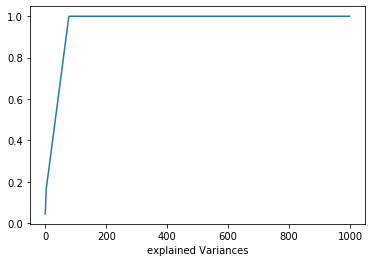

In [41]:
explained_variances=[i/np.sum(svd.explained_variance_ratio_) for i in svd.explained_variance_ratio_]
variances=[]
temp=0
for i in explained_variances:
    temp=temp+i
    variances.append(temp)
plt.plot(variances,label='Explained Variances')
plt.xlabel("explained Variances")
plt.show()

In [42]:
svd_opt=TruncatedSVD(n_components=130)
x_data=svd_opt.fit_transform(co_occ_mtrx)

# K-Means

## [5.2] Applying K-means on TFIDF,<font color='red'> SET 2</font>

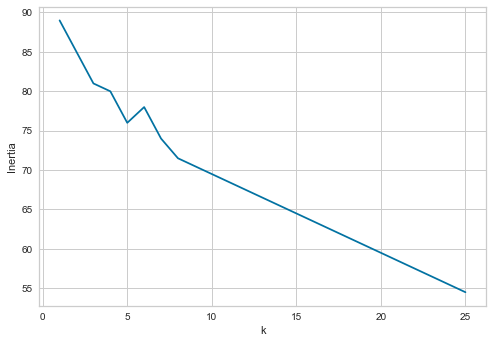

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer


n_clusters=[i for i in range(1,26)]
#n_clusters=[1,2]
inertia=[]
#K-Means Model
for k in n_clusters:
    k_means_clstr=KMeans(n_clusters=k,init='k-means++')
    k_means_clstr.fit(x_data)
    inertia.append(k_means_clstr.inertia_)



plt.plot(n_clusters,inertia,label='K vs Inertia')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()


In [44]:
opt_k_tf_idf=10
k_means_tf_idf=KMeans(n_clusters=opt_k_tf_idf,init='k-means++')
k_means_tf_idf.fit(x_data)


#print(cluster_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [45]:
print(set(k_means_tf_idf.labels_))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


<h4>WordCloud per cluster</h4>

In [46]:
cluster_data_tf_idf={}
for i in range(0,opt_k_tf_idf):    
    cluster_data_tf_idf['clust{0}'.format(i)]=[]
#print(cluster_data)
#Words extraction per cluster
for i in range(0,len(k_means_tf_idf.labels_)):              
    features=np.take(tf_idf_vect.get_feature_names(),x_train_tf_idf[i].indices).tolist()
    cluster_data_tf_idf['clust{0}'.format(k_means_tf_idf.labels_[i])] =  cluster_data_tf_idf['clust{0}'.format(k_means_tf_idf.labels_[i])]+features
#print(len(k_means_tf_idf.labels_))

WordCloud for Cluster : clust0  


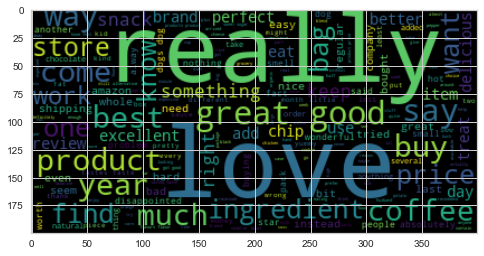

WordCloud for Cluster : clust1  


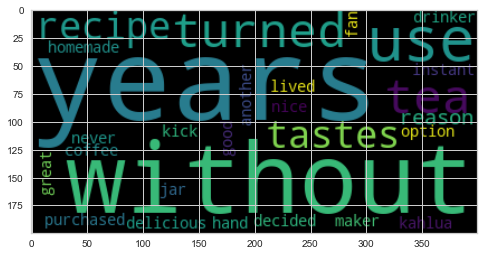

WordCloud for Cluster : clust2  


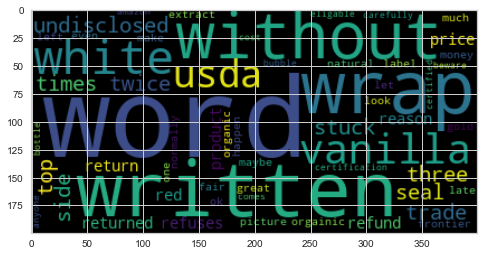

WordCloud for Cluster : clust3  


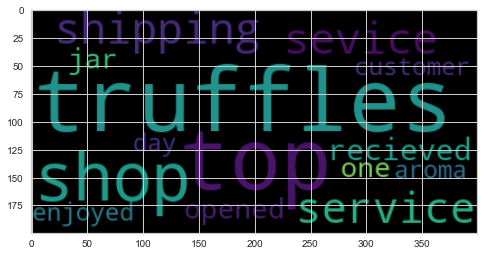

WordCloud for Cluster : clust4  


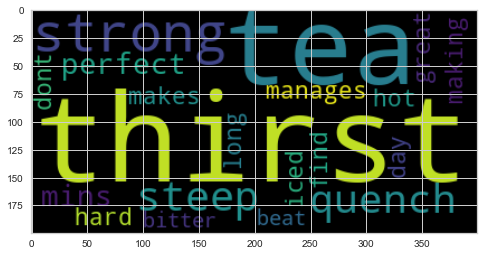

WordCloud for Cluster : clust5  


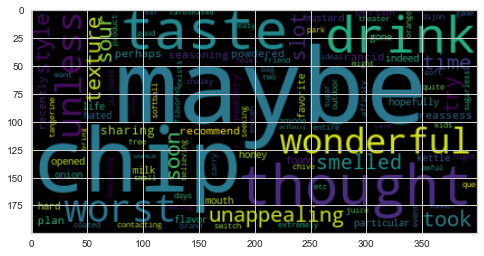

WordCloud for Cluster : clust6  


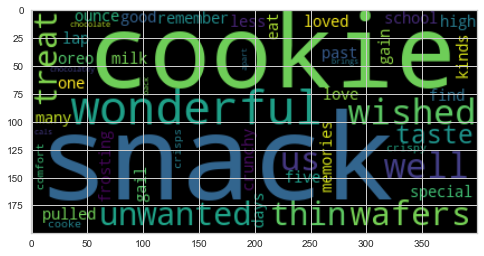

WordCloud for Cluster : clust7  


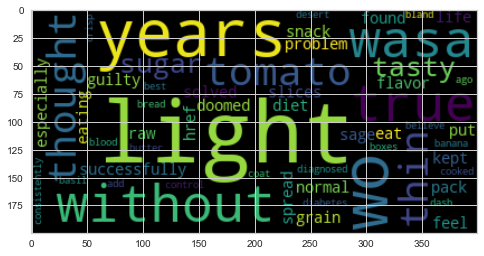

WordCloud for Cluster : clust8  


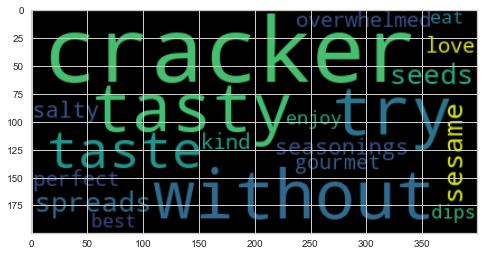

WordCloud for Cluster : clust9  


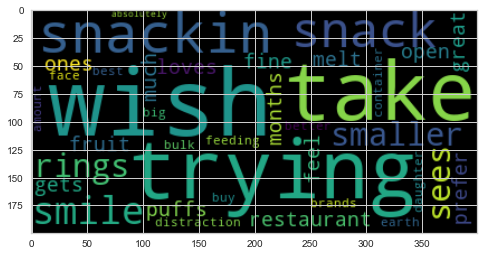

In [47]:
from  wordcloud  import WordCloud
for i in range(0,len(cluster_data_tf_idf)):
    #print(cluster_data_tf_idf['clust{0}'.format(i)])
    if cluster_data_tf_idf['clust{0}'.format(i)] != []:
        print("WordCloud for Cluster : clust{0}  ".format(i))
        text=' '.join([str(elem) for elem in cluster_data_tf_idf['clust{0}'.format(i)]])
        pos_rev=WordCloud().generate(text)
        plt.imshow(pos_rev,interpolation='bilinear')        
        plt.show()
        

In [50]:
from sklearn.metrics.pairwise import cosine_similarity

In [51]:
#to know what arguments does function or module take as input parameters
import inspect
inspect.getargspec(cosine_similarity)
inspect.getargspec(cosine_similarity.__init__)

ArgSpec(args=['self'], varargs='args', keywords='kwargs', defaults=None)

In [76]:
#https://github.com/Manish-12/Truncated-SVD-on-Amazon-fine-food-reviews-/blob/master/Truncated%20SVD.ipynb
def cos_sim(word):
    cos_sim_vec=cosine_similarity(svd_vec)
    sim_words_vec=cos_sim_vec[top_features.tolist().index(word)]
    print("similar words of {0} are {1}".format(word,np.take(top_features,sim_words_vec.argsort()[len(sim_words_vec)-10:])))



<h2>Top 10 similar words for a given word</h2>

In [77]:
cos_sim(top_features[0])
#top_features

similar words of owners are ['dash' 'wasteful' 'winner' 'plug' 'cuisinart' 'batter' 'chopped' 'glycol'
 'marzano' 'owners']


<h3>Conclusion :</h3>
<li> taken top 3000 features based on idf values.</li>
<li>Constructed a Co-occurance Matrix with these 3000 features</li>
<li>Applied Truncated SVD on co-occurance matrix with optimal number of components.</li>
<li>Applied Kmeans on truncated SVD to analyse the clusters.</li>
<li>We got the optimal k value from knee method is 10</li>
<li>for tf_idf vectorizer k-means developed wide range of clusters to group the data </li>
<li>We can observe from wordclouds that words per cluster are much similar </li>
<li>We can also observe that some features are included into different clusters this displays that these clusters are nearer to each other.</li>